# Solving puzzles using a quantum computer

In this workshop, we use one of the most important quantum algorithms such as [Grover's algorithm](https://arxiv.org/pdf/quant-ph/9605043.pdf) and this will be used to find the possible states in a situation that requires decision making to find the best solution to our situation.

<img src="image10.png" width="400" height="400">

In [1]:
# Qiskit libraries 
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import *

In [2]:
def init_qubits(init_input):
    len_init = len(init_input)
    q_variables = QuantumRegister(len_init)
    qc = QuantumCircuit(q_variables)
    for i,value in  enumerate(init_input):
        if value == 'x':
            qc.x(i)
        elif value == 'mt':
            qc.h(i)
    return qc.to_gate(label="init variables")

In [3]:
def general_conditions(conditions):
    inputs = QuantumRegister(9)
    qubit_conditions = QuantumRegister(8)
    
    qc = QuantumCircuit(inputs,qubit_conditions)
    for i,c in enumerate(conditions):
        qc.mcx(c,qubit_conditions[i])
    return qc.to_gate(label="general conditions")

In [4]:
def or_gate():
    q_reg = QuantumRegister(3)
    qc = QuantumCircuit(q_reg)
    qc.cx(q_reg[1], q_reg[2])
    qc.cx(q_reg[0], q_reg[2])
    qc.ccx(q_reg[0], q_reg[1], q_reg[2])
    return qc.to_gate(label="OR gate")

In [5]:
def indexPosicion(value):
    list_bin = []
    temp = bin(value)[2:]
    temp = temp[::-1]
    for i in range(len(temp)):
        if temp[i] == '1':
            list_bin.append(i)
    return list_bin

def particular_conditions(len_moves):               
     
    qubits_moves = QuantumRegister(len_moves)
    oracle = QuantumRegister(1)
    qc = QuantumCircuit(qubits_moves,oracle)
    qubits_list = [i for i in  range(len_moves)]
    
    for i in range(int(len_moves**2)):
        k = indexPosicion(i)
        if len(k) < len_moves/2:
            if k:
                qc.x(qubits_moves[k])
                qc.mcx(qubits_moves,oracle)
                qc.x(qubits_moves[k])
            else:
                qc.mcx(qubits_moves,oracle)
            #qc.barrier()
    return qc.to_gate(label="particular conditions")

In [6]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1) 
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    return qc.to_gate(label="diffuser")

In [7]:
def num_moves(init_input):
    moves = []
    for i,value in enumerate(init_input):
        if value == 'mt':
             moves.append(i)
    return moves,len(moves)

<>:87: SyntaxWarning: invalid escape sequence '\d'
<>:87: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_61841/1483814736.py:87: SyntaxWarning: invalid escape sequence '\d'
  'OR gate dg': "$\\vee^{\dagger}$"}})


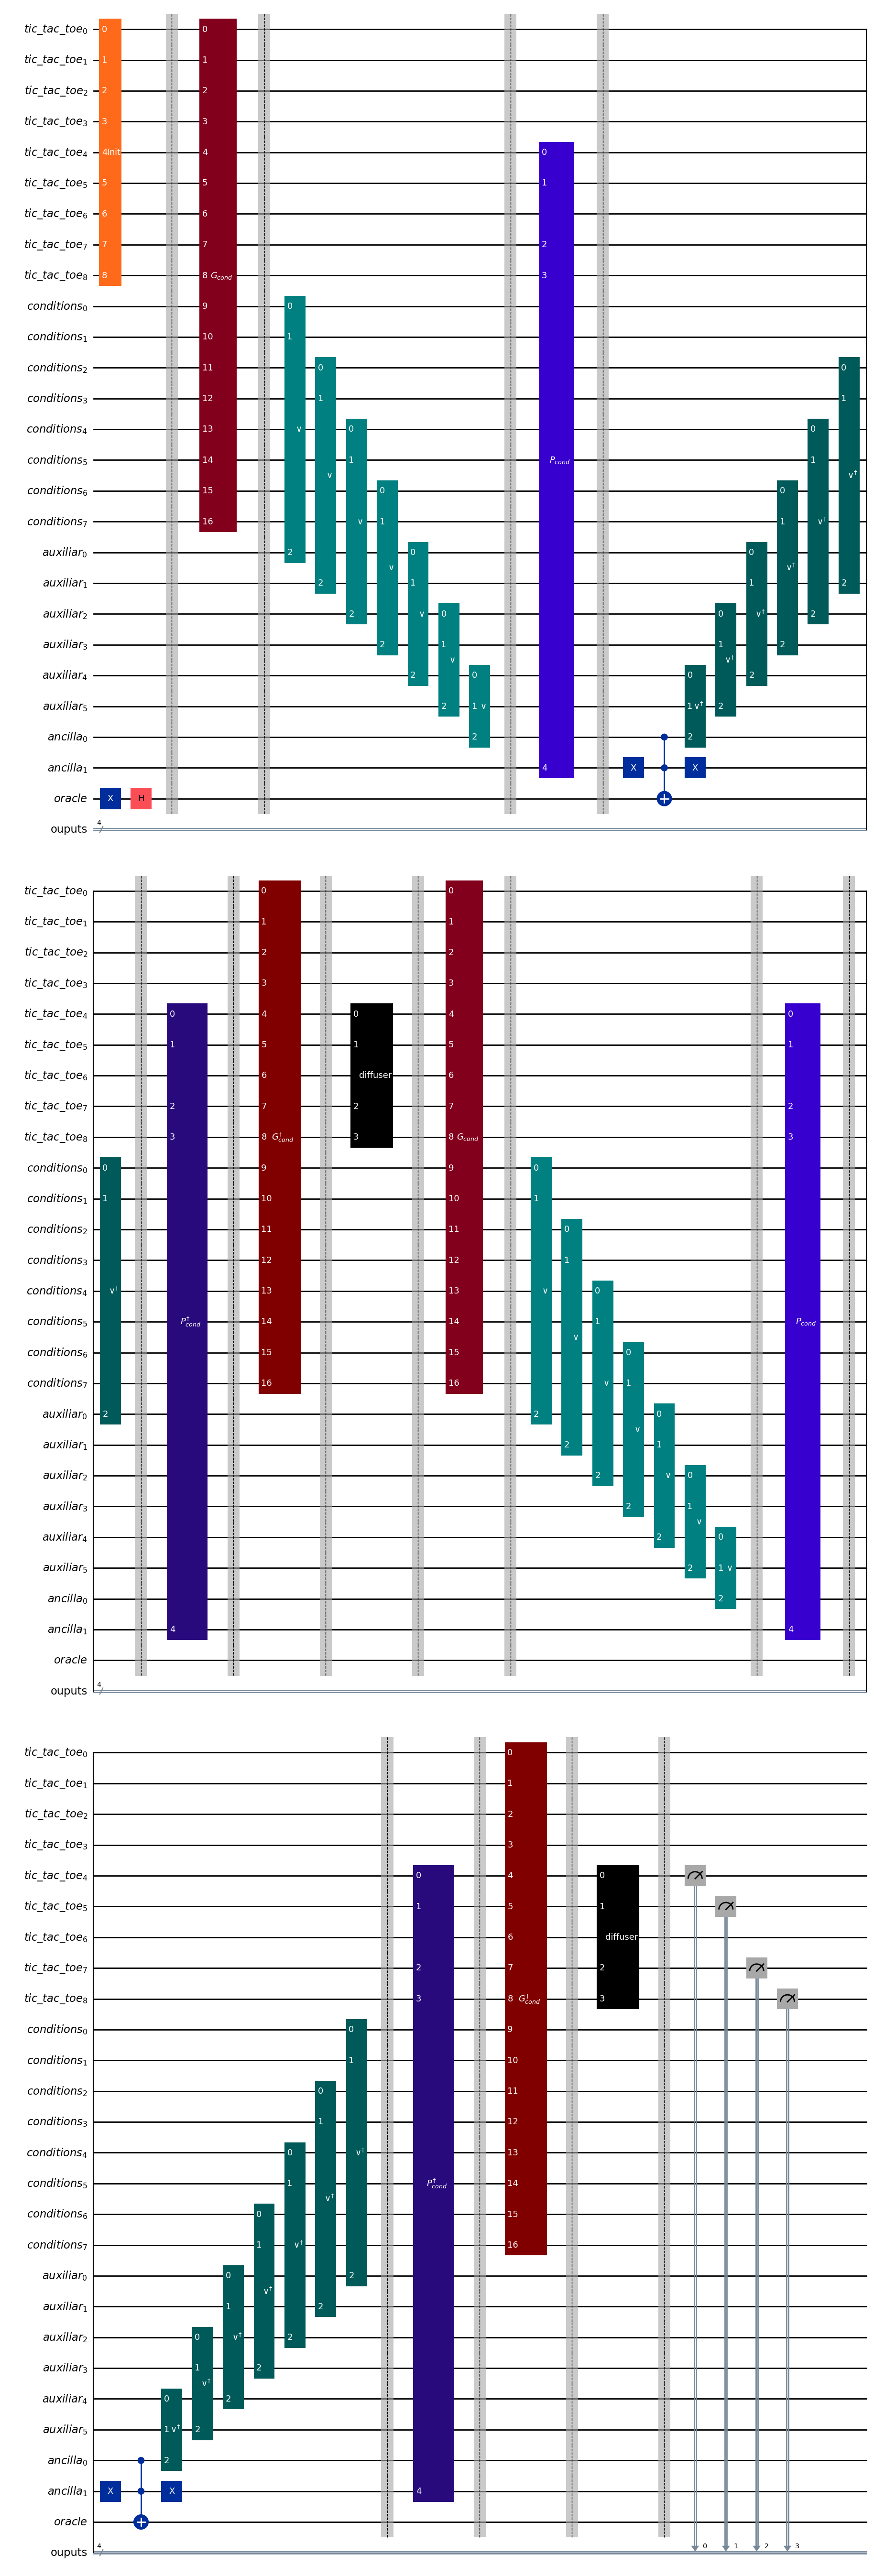

In [8]:
def tic_tac_toe(init_input):
    q_conditions = [[3,4,5],[0,4,8]]
    moves,len_moves = num_moves(init_input)
    
    
    inputs = QuantumRegister(9,"tic_tac_toe")
    conditions = QuantumRegister(8,"conditions")    
    auxiliar = QuantumRegister(6,"auxiliar")
    ancilla = QuantumRegister(2,"ancilla")
    oracle = QuantumRegister(1,"oracle")
    outputs = ClassicalRegister(len_moves,"ouputs")
    qc = QuantumCircuit(inputs,conditions,auxiliar,ancilla,oracle,outputs)
    qc.append(init_qubits(init_input),inputs)
    
    
    
    ## design the quantum circuit
    qc.x(oracle)
    qc.h(oracle)
    qc.barrier()

    
    
    for i in range(2):
        qc.append(general_conditions(q_conditions),inputs[:]+conditions[:])
        qc.barrier()
        qc.append(or_gate(),conditions[:2]+[auxiliar[0]])
        qc.append(or_gate(),conditions[2:4]+[auxiliar[1]])
        qc.append(or_gate(),conditions[4:6]+[auxiliar[2]])
        qc.append(or_gate(),conditions[6:8]+[auxiliar[3]])
        
        qc.append(or_gate(),auxiliar[:2]+[auxiliar[4]])
        qc.append(or_gate(),auxiliar[2:4]+[auxiliar[5]])
        
        qc.append(or_gate(),auxiliar[4:6]+[ancilla[0]])
        qc.barrier()
        qc.append(particular_conditions(len_moves),moves+[ancilla[1]])
        qc.barrier()
        qc.x(ancilla[1])
        qc.ccx(ancilla[0],ancilla[1],oracle)
        qc.x(ancilla[1])
        
        or_i = or_gate().inverse()
        or_i.name = "OR gate dg"
        
        qc.append(or_i,auxiliar[4:6]+[ancilla[0]])
        qc.append(or_i,auxiliar[2:4]+[auxiliar[5]])
        qc.append(or_i,auxiliar[:2]+[auxiliar[4]])
        qc.append(or_i,conditions[6:8]+[auxiliar[3]])
        qc.append(or_i,conditions[4:6]+[auxiliar[2]])
        qc.append(or_i,conditions[2:4]+[auxiliar[1]])
        qc.append(or_i,conditions[:2]+[auxiliar[0]])
        qc.barrier()
        
        pc_i = particular_conditions(len_moves).inverse() 
        pc_i.name = "particular conditions dg"
        qc.append(pc_i,moves+[ancilla[1]])
        qc.barrier()
        
        gc_i = general_conditions(q_conditions).inverse()
        gc_i.name = "general conditions dg"
        qc.append(gc_i,inputs[:]+conditions[:])
        qc.barrier()
        qc.append(diffuser(len_moves),moves)
        qc.barrier()
    qc.measure(moves,outputs)
    return qc
# x  will be equal to 1
# o  will be equal to 0
# mt means an empty cell  

init_input = ['x','o','o','x','mt','mt','o','mt','mt'] 

qc = tic_tac_toe(init_input)
qc.draw("mpl",style={'displaycolor': {'init variables': ('#fe6a1aff', '#FFFFFFFF'),
                                    'general conditions': ('#82001cff', '#FFFFFFFF'),
                                    'general conditions dg': ('#800000FF', '#FFFFFFFF'),
                                    'OR gate': ('#008080FF', '#FFFFFFFF'),
                                    'OR gate dg': ('#005a5aff', '#FFFFFFFF'),
                                    'particular conditions': ('#3700cfff', '#FFFFFFFF'),
                                    'particular conditions dg': ('#280a7dff', '#FFFFFFFF'),
                                    'diffuser': ('#000000', '#FFFFFF'),},
                    'displaytext': {'init variables':"Init",
                                    'general conditions':"$G_{cond}$",'general conditions dg': "$G_{cond}^{\\dagger}$",
                                    'particular conditions':"$P_{cond}$",'particular conditions dg': "$P_{cond}^{\\dagger}$",
                                    'OR gate': "$\\vee$",
                                    'OR gate dg': "$\\vee^{\dagger}$"}})

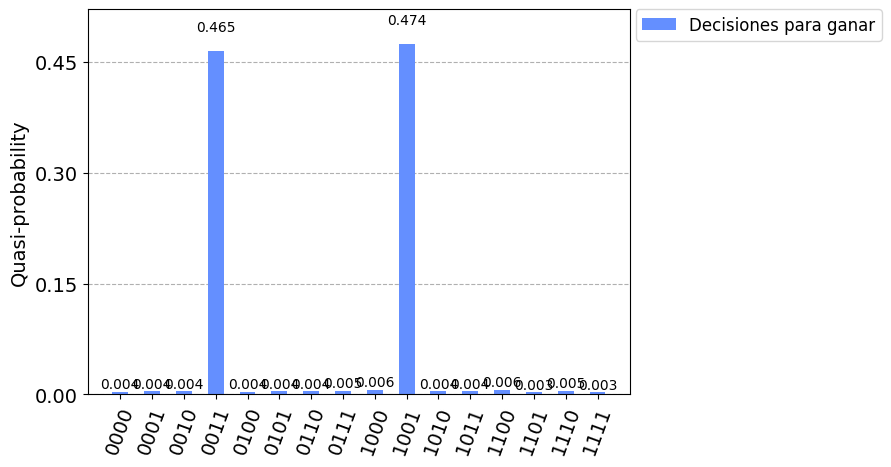

In [11]:
from qiskit_aer.primitives import Sampler  

sampler = Sampler()

job = sampler.run(qc,shots=10000)


counts = job.result().quasi_dists[0].binary_probabilities()


# graficamos los resultados con un histograma

legend = ["Decisiones para ganar"]
plot_histogram([counts], legend=legend)